### SECTION - A

In [3]:
import random
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

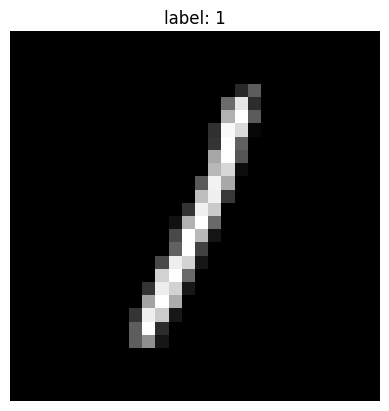

In [13]:
# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

rn = random.randint(0, len(x_train))

plt.imshow(x_train[rn], cmap='gray')
plt.title(f'label: {y_train[rn]}')
plt.axis('off')
plt.show()

In [5]:
# Create a dataset with rotated images
def rotate_images(images, labels):
    rotated_images = []
    rotated_labels = []
    
    for image, label in zip(images, labels):
        # Original image (0 degrees)
        rotated_images.append(image)
        rotated_labels.append(label)
        
        # Rotate 90 degrees
        rot_90 = tf.image.rot90(image)
        rotated_images.append(rot_90)
        rotated_labels.append(label)
        
        # Rotate 180 degrees
        rot_180 = tf.image.rot90(rot_90)
        rotated_images.append(rot_180)
        rotated_labels.append(label)
        
        # Rotate 270 degrees
        rot_270 = tf.image.rot90(rot_180)
        rotated_images.append(rot_270)
        rotated_labels.append(label)
    
    return np.array(rotated_images), np.array(rotated_labels)

In [14]:
# Create rotated datasets
x_train_rot, y_train_rot = rotate_images(x_train[:10000], y_train[:10000])
x_test_rot, y_test_rot = rotate_images(x_test[:1000], y_test[:1000])

print('X-TRAIN: ')
print(x_train_rot.shape, y_train_rot.shape)

print('X-TEST: ')
print(x_test_rot.shape, y_test_rot.shape)

X-TRAIN: 
(40000, 28, 28, 1) (40000,)
X-TEST: 
(4000, 28, 28, 1) (4000,)


In [ ]:
# Custom rotation-equivariant layer
class RotationEquivariantLayer(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(RotationEquivariantLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        
        # Create a single convolutional layer that will be shared
        self.conv = layers.Conv2D(filters, kernel_size, padding='same')
        
    def call(self, inputs):
        # Original orientation (0 degrees)
        x_0 = self.conv(inputs)
        
        # Rotate input 90 degrees, apply conv, then rotate output back
        x_90 = tf.image.rot90(inputs, k=1)
        x_90 = self.conv(x_90)
        x_90 = tf.image.rot90(x_90, k=3)  # Rotate back (270 degrees)
        
        # Rotate input 180 degrees, apply conv, then rotate output back
        x_180 = tf.image.rot90(inputs, k=2)
        x_180 = self.conv(x_180)
        x_180 = tf.image.rot90(x_180, k=2)  # Rotate back (180 degrees)
        
        # Rotate input 270 degrees, apply conv, then rotate output back
        x_270 = tf.image.rot90(inputs, k=3)
        x_270 = self.conv(x_270)
        x_270 = tf.image.rot90(x_270, k=1)  # Rotate back (90 degrees)
        
        # Average the outputs (this gives rotation equivariance)
        return (x_0 + x_90 + x_180 + x_270) / 4
    
    def get_config(self):
        config = super(RotationEquivariantLayer, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size
        })
        return config

In [19]:
# Verify the layer's equivariance property
def test_equivariance():
    # Create a test image
    test_image = x_test[0:1]
    
    # Create rotated versions
    rot_90 = tf.image.rot90(test_image)
    rot_180 = tf.image.rot90(rot_90)
    rot_270 = tf.image.rot90(rot_180)
    
    # Create layer instance
    layer = RotationEquivariantLayer(16, (3, 3))
    
    # Apply layer to each rotation
    output_0 = layer(test_image)
    output_90 = layer(rot_90)
    output_180 = layer(rot_180)
    output_270 = layer(rot_270)
    
    # Rotate outputs to compare
    rotated_output_90 = tf.image.rot90(output_90, k=3)
    rotated_output_180 = tf.image.rot90(output_180, k=2)
    rotated_output_270 = tf.image.rot90(output_270, k=1)
    
    # Check if outputs are similar (should be nearly identical for perfect equivariance)
    diff_90 = tf.reduce_mean(tf.abs(output_0 - rotated_output_90))
    diff_180 = tf.reduce_mean(tf.abs(output_0 - rotated_output_180))
    diff_270 = tf.reduce_mean(tf.abs(output_0 - rotated_output_270))
    
    print(f"Mean absolute difference (0° vs 90°): {diff_90.numpy()}")
    print(f"Mean absolute difference (0° vs 180°): {diff_180.numpy()}")
    print(f"Mean absolute difference (0° vs 270°): {diff_270.numpy()}")
    
    return diff_90.numpy(), diff_180.numpy(), diff_270.numpy()


In [ ]:
# Create regular CNN model
def create_regular_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

regular_model = create_regular_model()

# Create equivariant CNN model
class EquivariantModel(keras.models.Model):
    def __init__(self, num_class = 10, input_shape = (28, 28, 1), kernel_size = (3, 3), output_size = [32, 64], is_visual = False):
        super(EquivariantModel, self).__init__()
        
        self.is_visual = is_visual
        self.eq_layer_1 = RotationEquivariantLayer(filters=output_size[0], kernel_size=kernel_size, input_shape=input_shape)
        self.eq_layer_2 = RotationEquivariantLayer(filters=output_size[-1], kernel_size=kernel_size)
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(num_class, activation='softmax')

    
    def call(self, x):
        
        x_eq_1 = self.eq_layer_1(x)
        x = layers.Activation('relu')(x_eq_1) ## NO params here
        x = layers.MaxPooling2D((2, 2))(x)

        x_eq_2 = self.eq_layer_2(x)
        x = layers.Activation('relu')(x_eq_2) ## NO params here
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = layers.Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)

        # if self.is_visual:
        #     self.visual([x_eq_1, x_eq_2])

        return x
    
    def visual(self, x_eq):
        '''
        Plots the Evolution of Response Maps (by Equivariance Layers)
        '''
        x_eq_1, x_eq_2 = x_eq

        fig, axs = plt.subplots(1, 2, figsize=(6, 6))
        
        axs[0].imshow(x_eq_1[0, :, :, 0], cmap='gray')
        axs[1].imshow(x_eq_2[0, :, :, 0], cmap='gray')

        axs[0].set_title('Equivariance-Layer-1')
        axs[1].set_title('Equivariance-Layer-2')

        plt.show()

class ResponseMapVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, sample_input, frequency=1):
        super().__init__()
        self.sample_input = sample_input
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:  # Visualize every 'frequency' epochs
            # Create submodel to get intermediate outputs
            submodel = keras.Model(inputs=self.model.input, 
                                   outputs=[self.model.eq_layer_1.output, self.model.eq_layer_2.output])
            outputs = submodel.predict(self.sample_input)
            self.model.visual(outputs)

eq_model = EquivariantModel(is_visual=True)
eq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(' --- MODEL SUMMARY --- ')
regular_model.summary()
print()
eq_model.summary()

 --- MODEL SUMMARY --- 


c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Alik\AppData\Local\Temp\ipykernel_18912\2926765303.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RotationEquivariantLayer, self).__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_52 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Model: "equivariant_model_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rotation_equivariant_layer_45   │ ?                      │   0 (unbuilt) │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_equivariant_layer_46   │ ?                      │   0 (unbuilt) │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mean absolute difference (0° vs 90°): 7.259259103686161e-22
Mean absolute difference (0° vs 180°): 7.5250408576957755e-22
Mean absolute difference (0° vs 270°): 7.661829086225609e-22



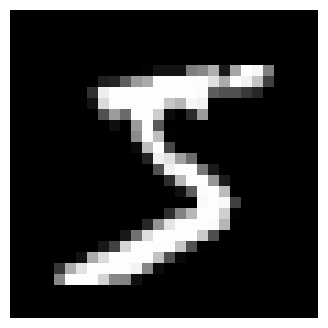

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0547 - loss: 2.3028tf.Tensor(
[[0.09817953 0.10179118 0.10116448 0.10031916 0.10160413 0.09847417
  0.09849759 0.10041094 0.09929615 0.10026261]], shape=(1, 10), dtype=float32)


AttributeError: The layer equivariant_model_16 has never been called and thus has no defined input.

In [55]:
# Test equivariance property
diffs = test_equivariance()
print()
# # Train and evaluate regular model
# regular_model = create_regular_model()
# regular_history = regular_model.fit(
#     x_train_rot, y_train_rot,
#     epochs=5,
#     batch_size=64,
#     validation_split=0.2,
#     verbose=1
# )

# regular_score = regular_model.evaluate(x_test_rot, y_test_rot)
# print(f"Regular CNN - Test Loss: {regular_score[0]}, Test Accuracy: {regular_score[1]}")

sample_input = x_train_rot[:1].reshape(1, 28, 28, 1)
plt.figure(figsize=(4, 4))
plt.imshow(sample_input[0], cmap='gray')
plt.axis('off')
plt.show()

viz_callback = ResponseMapVisualizationCallback(sample_input=sample_input, frequency=1)

# Train and evaluate equivariant model
equivariant_history = eq_model.fit(
    x_train_rot, y_train_rot,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[viz_callback],
    verbose=1,
    steps_per_epoch=5
)

equivariant_score = eq_model.evaluate(x_test_rot, y_test_rot)
print(f"Equivariant CNN - Test Loss: {equivariant_score[0]}, Test Accuracy: {equivariant_score[1]}")


In [ ]:
# Plot training histories
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(regular_history.history['accuracy'], label='Regular - Training')
plt.plot(regular_history.history['val_accuracy'], label='Regular - Validation')
plt.plot(equivariant_history.history['accuracy'], label='Equivariant - Training')
plt.plot(equivariant_history.history['val_accuracy'], label='Equivariant - Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(regular_history.history['loss'], label='Regular - Training')
plt.plot(regular_history.history['val_loss'], label='Regular - Validation')
plt.plot(equivariant_history.history['loss'], label='Equivariant - Training')
plt.plot(equivariant_history.history['val_loss'], label='Equivariant - Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('rotation_equivariant_performance.png')
plt.show()